In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import os

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [3]:
def read_data(sample_name):
    path = '/project01/ndcms/cmoore24/skims/skimmed_jets/mc/nolepton/tagged'
    dir_contents = os.listdir(path)
    wanted_samples = []
    for i in dir_contents:
        if sample_name in i:
            wanted_samples.append(i)
    sample_dict = {}
    for i in wanted_samples:
        sample_dict[f'{i.replace(".parquet", "")}'] = ak.from_parquet(f'{path}/{i}')
    return sample_dict

In [4]:
mc = {}
mc['zqq'] = read_data('zqq')
mc['wqq'] = read_data('wqq')
mc['ttboosted']= read_data('ttboosted')
mc['diboson'] = read_data('diboson')
mc['hbb'] = read_data('hbb')
mc['hgg'] = read_data('hgg')
mc['qcd'] = read_data('qcd')
mc['singletop'] = read_data('singletop')

In [5]:
data = ak.from_parquet('/project01/ndcms/cmoore24/skims/skimmed_jets/data/nolepton/tagged/*')

In [6]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return sample

In [7]:
data_jets = nan_remover(data.goodjets)

In [8]:
mc_jets = {}
for i in mc:
    mc_jets[i] = {}
    for j in mc[i]:
        mc_jets[i][j] = nan_remover(mc[i][j].goodjets)

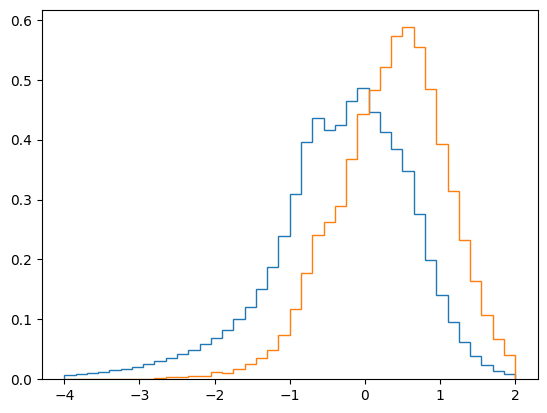

In [9]:
plt.hist(data_jets.ecf_tagger, bins=40, histtype='step', range=(-4, 2), density=True)
plt.hist(mc_jets['hgg']['hgg'].ecf_tagger, bins=40, histtype='step', range=(-4, 2), density=True)
plt.show()

In [10]:
def bkg_output_hist(sample_name, wp, fail, sample_prefix=None):
    if sample_prefix != None:
        sample = mc_jets[sample_prefix][sample_name]
    else:
        sample = mc_jets[sample_name]
    
    if fail:
        mask = ~((sample.ecf_tagger >= wp))
        sample_cut_msd = sample.msoftdrop[mask]
    else:
        mask = (sample.ecf_tagger >= wp)
        sample_cut_msd = sample.msoftdrop[mask]
    try:
        msd_hist = hist.Hist.new.Reg(40, 80, 170, name=f"msd", label=f"MSD").Weight()
    except:
        msd_hist = hist.Hist.new.Reg(40, 80, 170, name=f"msd", label=f"MSD").Weight()
    msd_hist.fill(msd=sample_cut_msd)
    return msd_hist

In [34]:
cut = 0.4

In [354]:
pass_hists = {}
for i in mc_jets:
    if type(mc_jets[i]) == dict:
        for j in mc_jets[i]:
            msd_hist = bkg_output_hist(j, wp=cut, fail=False, sample_prefix=i)
            pass_hists[j] = msd_hist
    else:
        msd_hist = bkg_output_hist(i, wp=cut, fail=False)
        pass_hists[i] = msd_hist

In [355]:
fail_hists = {}
for i in mc_jets:
    if type(mc_jets[i]) == dict:
        for j in mc_jets[i]:
            msd_hist = bkg_output_hist(j, wp=cut, fail=True, sample_prefix=i)
            fail_hists[j] = msd_hist
    else:
        msd_hist = bkg_output_hist(i, wp=cut, fail=True)
        fail_hists[i] = msd_hist

In [356]:
with open('subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
del(totals['ww4q'])

In [357]:
with open('my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [358]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
fail_hists['hgg'].view(flow=True)[:] *= scaleHgg
pass_hists['hgg'].view(flow=True)[:] *= scaleHgg

In [359]:
scaleHbb = ((44.99*(xsecs['hbb']*1000)*0.579)/(totals['hbb']))
fail_hists['hbb'].view(flow=True)[:] *= scaleHbb
fail_hists['hbb'].view(flow=True)[:] *= scaleHbb

In [360]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [361]:
#xsecs['qcd_300to470'] = 6833*0.9

In [362]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [363]:
#totals['qcd_300to470'] = 21500000

In [364]:
del(pass_hists['wqq_200to400'])
del(fail_hists['wqq_200to400'])

del(pass_hists['zqq_200to400'])
del(fail_hists['zqq_200to400'])

del(pass_hists['diboson_ww4q'])
del(fail_hists['diboson_ww4q'])

In [365]:
xsecs['diboson_ww'] = xsecs['ww']
xsecs['diboson_zz'] = xsecs['zz']
xsecs['diboson_wz'] = xsecs['wz']

totals['diboson_ww'] = totals['ww']
totals['diboson_zz'] = totals['zz']
totals['diboson_wz'] = totals['wz']

In [366]:
for i in pass_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
    pass_hists[i].view(flow=True)[:] *= scale

In [367]:
for i in fail_hists:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
    fail_hists[i].view(flow=True)[:] *= scale

In [368]:
qcd_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('qcd')) #*0.0001
qcd_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('qcd'))

wqq_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('wqq'))
wqq_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('wqq'))

zqq_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('zqq'))
zqq_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('zqq'))

ttboosted_pass_hist = sum(value for key, value in pass_hists.items() if key.startswith('ttboosted'))
ttboosted_fail_hist = sum(value for key, value in fail_hists.items() if key.startswith('ttboosted'))

In [369]:
pass_hists2 = {}
pass_hists2['qcd'] = qcd_pass_hist
pass_hists2['wqq'] = wqq_pass_hist
pass_hists2['zqq'] = zqq_pass_hist
pass_hists2['ttboosted'] = ttboosted_pass_hist
pass_hists2['ww'] = pass_hists['diboson_ww']
pass_hists2['wz'] = pass_hists['diboson_wz']
pass_hists2['zz'] = pass_hists['diboson_zz']
pass_hists2['singletop'] = pass_hists['singletop']
pass_hists2['hbb'] = pass_hists['hbb']
pass_hists2['hgg'] = pass_hists['hgg']
pass_hists = pass_hists2

In [370]:
fail_hists2 = {}
fail_hists2['qcd'] = qcd_fail_hist
fail_hists2['wqq'] = wqq_fail_hist
fail_hists2['zqq'] = zqq_fail_hist
fail_hists2['ttboosted'] = ttboosted_fail_hist
fail_hists2['ww'] = fail_hists['diboson_ww']
fail_hists2['wz'] = fail_hists['diboson_wz']
fail_hists2['zz'] = fail_hists['diboson_zz']
fail_hists2['singletop'] = fail_hists['singletop']
fail_hists2['hbb'] = fail_hists['hbb']
fail_hists2['hgg'] = fail_hists['hgg']
fail_hists = fail_hists2

In [371]:
total_hists = {}
for i in pass_hists:
    total_hists[i] = pass_hists[i] + fail_hists[i]

In [372]:
mc_hist = sum([total_hists[i] for i in total_hists])
mc_pass = sum([pass_hists[i] for i in pass_hists])

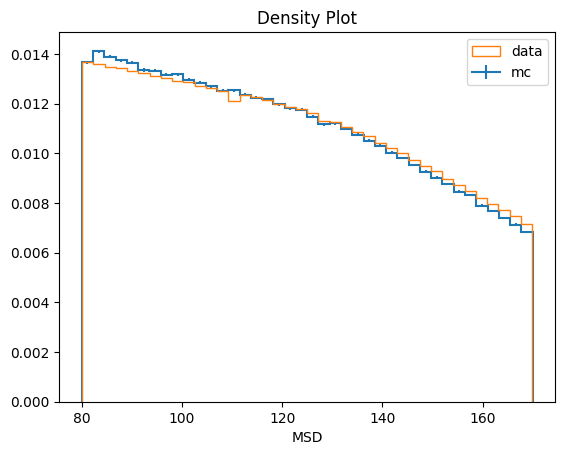

In [373]:
mc_hist.plot1d(label='mc', density=True)
plt.hist(data_jets.msoftdrop, bins=40, histtype='step', label='data', density=True)
plt.title('Density Plot')
plt.legend()
plt.show()

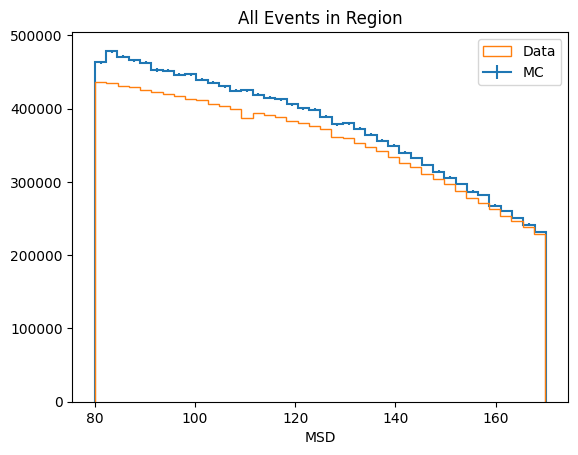

In [374]:
mc_hist.plot1d(label='MC', density=False)
plt.hist(data_jets.msoftdrop, bins=40, histtype='step', label='Data', density=False)
plt.title('All Events in Region')
plt.legend()
plt.show()

In [375]:
mask = ((data_jets.ecf_tagger >= 0.4))
data_cut_msd = data_jets.msoftdrop[mask]
data_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Data MSD').Weight()
data_pass_hist.fill(msd=data_cut_msd);

In [376]:
mask = ((data_jets.ecf_tagger < 0.4))
data_cut_msd = data_jets.msoftdrop[mask]
data_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Data MSD').Weight()
data_fail_hist.fill(msd=data_cut_msd);

In [377]:
total_data_hist = data_pass_hist + data_fail_hist

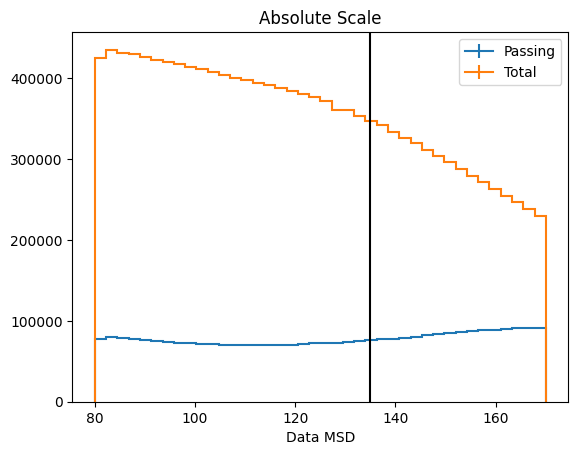

In [378]:
data_pass_hist.plot1d(density=False, label='Passing')
total_data_hist.plot1d(density=False, label='Total')
plt.title('Absolute Scale')
plt.axvline(135, color='black')
plt.legend()
plt.show()

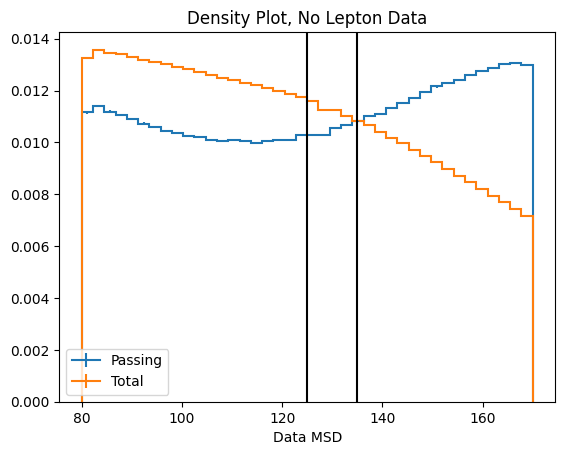

In [379]:
data_pass_hist.plot1d(density=True, label='Passing')
total_data_hist.plot1d(density=True, label='Total')
plt.title('Density Plot, No Lepton Data')
plt.axvline(135, color='black')
plt.axvline(125, color='black')
plt.legend()
plt.show()

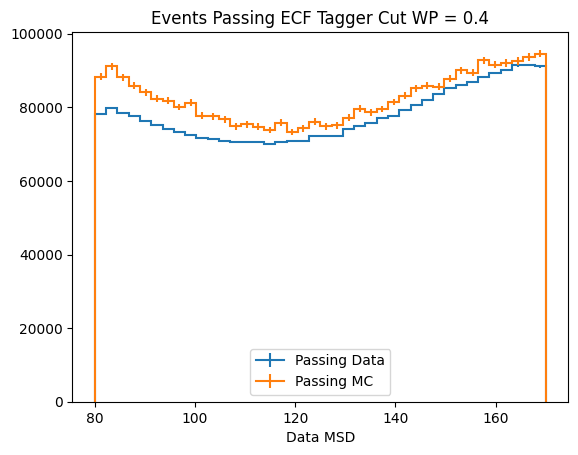

In [380]:
data_pass_hist.plot1d(density=False, label='Passing Data')
mc_pass.plot1d(density=False, label='Passing MC')
plt.title('Events Passing ECF Tagger Cut WP = 0.4')
plt.legend()
plt.show()